In [19]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
from model2 import get_model
import torch

model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = get_model()


Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import nltk
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import Dataset, DataLoader

# Download the Penn TreeBank dataset
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [21]:
from nltk.corpus import treebank

# Load the dataset
sentences = treebank.tagged_sents()


In [26]:
len(sentences)

3914

In [18]:
text = "A test example"
model = model.to("cuda")
inputs = tokenizer(text, return_tensors="pt").to("cuda")
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)
predictions = predictions.cpu().numpy()

# Convert to labels
label_list = model.config.id2label
labeled_predictions = [label_list[id] for id in predictions[0]]

# Combine tokens and predictions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
result = list(zip(tokens, labeled_predictions))

print(result)

[('[CLS]', 'NN'), ('A', 'DT'), ('test', 'NN'), ('example', 'NN'), ('[SEP]', 'NN')]


In [8]:
for n,m in model.named_modules():
    print(n)
    # print(m)


bert
bert.embeddings
bert.embeddings.word_embeddings
bert.embeddings.position_embeddings
bert.embeddings.token_type_embeddings
bert.embeddings.LayerNorm
bert.embeddings.dropout
bert.encoder
bert.encoder.layer
bert.encoder.layer.0
bert.encoder.layer.0.attention
bert.encoder.layer.0.attention.self
bert.encoder.layer.0.attention.self.query
bert.encoder.layer.0.attention.self.key
bert.encoder.layer.0.attention.self.value
bert.encoder.layer.0.attention.self.dropout
bert.encoder.layer.0.attention.output
bert.encoder.layer.0.attention.output.dense
bert.encoder.layer.0.attention.output.LayerNorm
bert.encoder.layer.0.attention.output.dropout
bert.encoder.layer.0.intermediate
bert.encoder.layer.0.intermediate.dense
bert.encoder.layer.0.intermediate.intermediate_act_fn
bert.encoder.layer.0.output
bert.encoder.layer.0.output.dense
bert.encoder.layer.0.output.LayerNorm
bert.encoder.layer.0.output.dropout
bert.encoder.layer.1
bert.encoder.layer.1.attention
bert.encoder.layer.1.attention.self
bert.e

In [32]:
import nltk
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW
from sklearn.metrics import f1_score

# Download the Penn TreeBank dataset
nltk.download('treebank')

from nltk.corpus import treebank

# Load the dataset
sentences = treebank.tagged_sents()

# Split the dataset into train and test sets
train_size = int(0.8 * len(sentences))
train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]

class PennTreebankDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tag2id = {tag: i for i, tag in enumerate(set([tag for sent in self.sentences for _, tag in sent]))}
        self.id2tag = {i: tag for tag, i in self.tag2id.items()}

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence, tags = zip(*self.sentences[idx])
        sentence = " ".join(sentence)
        
        encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        # Align tags with tokenized words
        aligned_tags = []
        words = self.tokenizer.tokenize(sentence)
        for word, tag in zip(sentence.split(), tags):
            tokens = self.tokenizer.tokenize(word)
            aligned_tags.extend([tag] * len(tokens))
        
        # Pad or truncate tags to match input_ids length
        if len(aligned_tags) > self.max_length - 2:
            aligned_tags = aligned_tags[:self.max_length - 2]
        
        # Add tags for [CLS] and [SEP]
        aligned_tags = [aligned_tags[0]] + aligned_tags + [aligned_tags[-1]]
        
        # Pad with the last tag if necessary
        aligned_tags += [aligned_tags[-1]] * (self.max_length - len(aligned_tags))
        
        # Convert tags to IDs
        tag_ids = [self.tag2id[tag] for tag in aligned_tags]
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(tag_ids)
        }
# Set up the model and tokenizer
model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Create datasets and dataloaders
train_dataset = PennTreebankDataset(train_sentences, tokenizer)
test_dataset = PennTreebankDataset(test_sentences, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation and F1 score calculation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # Remove padding and special tokens
        for pred, label, mask in zip(predictions, labels, attention_mask):
            pred = pred[mask.bool()][1:-1]
            label = label[mask.bool()][1:-1]
            all_predictions.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=list(train_dataset.tag2id.keys())))

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

Weighted F1 Score: 0.1134

Classification Report:
              precision    recall  f1-score   support

          RP       0.69      0.85      0.76        34
         JJS       0.90      0.98      0.94        45
          RB       0.95      0.98      0.97       630
          TO       1.00      1.00      1.00       464
         JJR       0.92      0.95      0.94        84
          IN       0.99      0.98      0.99      1953
         PDT       0.00      0.00      0.00         6
         SYM       0.00      0.00      0.00        28
         WRB       0.00      0.00      0.00       602
          LS       0.00      0.00      0.00       104
         VBN       0.00      0.00      0.00       597
       -RRB-       0.00      0.00      0.00       388
          VB       0.00      0.00      0.00      1768
         VBZ       0.00      0.00      0.00      3741
          JJ       0.00      0.00      0.00       930
           ,       0.00      0.00      0.00       106
          NN       0.00      0.

/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [41]:
import nltk
from nltk.corpus import treebank
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from transformers import pipeline
from sklearn.metrics import classification_report

# Download the treebank dataset
nltk.download('treebank')

# Load the model and tokenizer
model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Get the tag set and label mapping
label_list = model.config.id2label

# Load the dataset
sentences = treebank.tagged_sents()

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
from torch.utils import data
class PosDataset(data.Dataset):
    def __init__(self, tagged_sents,tokenizer,tag2idx,idx2tag):
        sents, tags_li = [], [] # list of lists
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.idx2tag = idx2tag
        for sent in tagged_sents:
            words = [word_pos[0] for word_pos in sent]
            tags = [word_pos[1] for word_pos in sent]
            sents.append(["[CLS]"] + words + ["[SEP]"])
            tags_li.append(["<pad>"] + tags + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

        # We give credits only to the first piece.
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = self.tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = self.tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [self.tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen

In [48]:
tagged_sents = treebank.tagged_sents()
print(len(tagged_sents))
print(tagged_sents[0])
tags = list(set(word_pos[1] for sent in tagged_sents for word_pos in sent))
tags = ["<pad>"] + tags
tags_str = ','.join(tags)
print(len(tags_str))
print(tags_str)
tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}
dataset = PosDataset(sentences,tokenizer,tag2idx,idx2tag)

3914
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
170
<pad>,RP,JJS,RB,TO,JJR,IN,PDT,SYM,WRB,LS,VBN,-RRB-,VB,VBZ,JJ,,,NN,:,-LRB-,``,NNPS,#,PRP$,NNS,$,EX,WDT,VBD,PRP,VBG,.,UH,POS,'',RBR,MD,CD,CC,VBP,-NONE-,FW,WP$,NNP,WP,RBS,DT


In [69]:
from tqdm import tqdm
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for words, x, is_heads, tags, y, seqlen in tqdm(dataset):
        
        x = torch.tensor(x).unsqueeze(0)
        outputs = model(x).logits
        predictions = torch.argmax(outputs, dim=2).squeeze().tolist()
        
        

  0%|          | 0/3914 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [65]:
true_labels[0]

['<',
 'p',
 'a',
 '>',
 ' ',
 'N',
 'N',
 'P',
 ' ',
 'N',
 'N',
 'P',
 ' ',
 ',',
 ' ',
 'N',
 'N',
 ' ',
 'J',
 'J']

In [66]:
pred_labels[0]

['.',
 'NNP',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 ',',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 'DT',
 'JJ',
 'NN',
 'NNP',
 'CD',
 '.',
 '.']

In [ ]:
from datasets import load_dataset, concatenate_datasets

from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
import random
import numpy as np
from utilities import evaluate_gpt2_classification as evaluate_gpt2_classification, mask_range_gpt,compute_masks, reset_gpt, compute_mask_probe
import torch  
from tqdm import tqdm

dataset_name = "dair-ai/emotion"

text_tag = "text"

# Load dataset and tokenizer


tables = []
layer = 11
# for i in tqdm(range(1, 21)):
per = 0.3
print("Percentage: ", per)
num_classes = 6

# tao = 2.5

lab = "label"
# tao = torch.inf

dataset = load_dataset(dataset_name)

print(dataset)
# Set random seed
seed_value = 42  # or any other integer

random.seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():  # PyTorch-specific
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

import torch

torch.autograd.set_detect_anomaly(True)
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


special_tokens_dict = {}
new_tokens = []
label2text = dataset['train'].features[lab].names

for label in label2text:
    # Create special token format (with and without space)
    special_token = f'{label}'
    
    # Check if the label is already a single token in the tokenizer
    label_tokens = tokenizer.encode(label, add_special_tokens=False)
    is_single_token = len(label_tokens) == 1
    
    if is_single_token:
        print(f"'{label}' is already a single token (ID: {label_tokens[0]})")
    
    # Add both versions to new tokens list
    new_tokens.extend([special_token])

# Add the tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(new_tokens)
print(f"\nAdded {num_added_tokens} new tokens to the tokenizer")

special_tokens = {
    'pad_token': '<|pad|>',
    'sep_token': '<|sep|>',
    'eos_token': '<|eos|>'
}
tokenizer.add_special_tokens(special_tokens)

def format_data(examples):
    formatted_texts = []
    for text, label in zip(examples[text_tag], examples[lab]):
        # Convert label to string
        
        tok_text = tokenizer.encode(text, max_length=400, truncation=True)
        text = tokenizer.decode(tok_text)
        label_str = dataset['train'].features[lab].int2str(label)
        formatted_text = f"Classify emotion: {text}{tokenizer.sep_token}"#{label_str}{tokenizer.eos_token}"
        formatted_texts.append(formatted_text)
    return {'formatted_text': formatted_texts}

def tokenize_and_prepare(examples):

    # Tokenize with batch processing
    tokenized = tokenizer(
        examples['formatted_text'],
        padding='max_length',
        max_length=408,
        truncation=True,
        return_tensors="pt"
    )
    
    # Clone input_ids to create labels
    labels = tokenized['input_ids'].clone()
    
    # Find the position of sep_token
    sep_token_id = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
    sep_positions = (labels == sep_token_id).nonzero(as_tuple=True)
    
    # Mask all tokens with -100 except for the token right after sep_token
    labels[:] = -100  # Mask all initially
    for batch_idx, sep_pos in zip(*sep_positions):
        if sep_pos + 1 < labels.size(1):
            labels[batch_idx, sep_pos + 1] = tokenized['input_ids'][batch_idx, sep_pos + 1]
    
    # Set padding tokens to -100
    labels[labels == tokenizer.pad_token_id] = -100
    
    return {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'labels': labels
    }
# Process the dataset
formatted_dataset = dataset.map(format_data, batched=True)
tokenized_dataset = formatted_dataset.map(
    tokenize_and_prepare, 
    batched=True,
)

from transformers import GPT2LMHeadModel as gt
from models.gpt2 import GPT2LMHeadModel
# Load pre-trained GPT-2 model
model1 = gt.from_pretrained('gpt2')

model1.resize_token_embeddings(len(tokenizer))

model1.config.m_layer = layer
import os

base_path = os.path.join("model_weights", dataset_name)
if not os.path.exists(base_path):
    os.makedirs(base_path)

weights_path = os.path.join(base_path, "weights.pth")

model = GPT2LMHeadModel(model1.config)


model.load_state_dict(torch.load(weights_path))




from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.tensor")

batch_size = 2048/2
# mask_layer = 5
compliment = True
results_table = PrettyTable()
if(compliment):
    results_table.field_names = results_table.field_names = ["Class", "Base Accuracy", "Base Confidence", "Base Complement Acc", "Base Compliment Conf", "STD Accuracy", "STD Confidence", "STD compliment ACC", "STD compliment Conf", "MAX Accuracy", "MAX Confidence", "Max compliment acc", "Max compliment conf", "Total Masked", "Intersection"]#, "Same as Max"]#"MAX Accuracy", "MAX Confidence", "Max compliment acc", "Max compliment conf"

class_labels = []
base_accuracies = []
base_confidences = []
base_comp_acc = []
base_comp_conf = []
std_masked_counts = []
std_accuracies = []
std_confidences = []
std_comp_acc = []
std_comp_conf = []
max_masked_counts = []
max_accuracies = []
max_confidences = []
max_comp_acc = []
max_comp_conf = []
diff_from_max = []
total_masked = []

#merge test and train set and then shuffle and make splits

# First merge and shuffle
tokenized_dataset = concatenate_datasets([tokenized_dataset['train'], tokenized_dataset['test']]).shuffle(seed=42)

# Get the total length
dataset_length = len(tokenized_dataset)

# Calculate split index
split_index = int(dataset_length * 0.2)  # 80% for training

# Create the splits using dataset slicing
tokenized_dataset1 = tokenized_dataset.select(range(split_index))  # training set
recording_dataset = tokenized_dataset.select(range(split_index, dataset_length))

all_fc_vals = []
print("Recording activations...")
for j in range(0,num_classes):
    dataset_recording = recording_dataset.filter(lambda x: x[lab] in [j])
    fc_vals = evaluate_gpt2_classification(lab, model, dataset_recording, tokenizer)
    fc_vals = fc_vals[2]
    all_fc_vals.append(fc_vals)
    
# save all_fc_vals to file
import pickle

# with open('all_fc_vals.pkl', 'wb') as f:
#     pickle.dump(all_fc_vals, f)
    
# # # Load all_fc_vals from file
# # with open('all_fc_vals.pkl', 'rb') as f:
# #     all_fc_vals = pickle.load(f)





Creating combined plot...


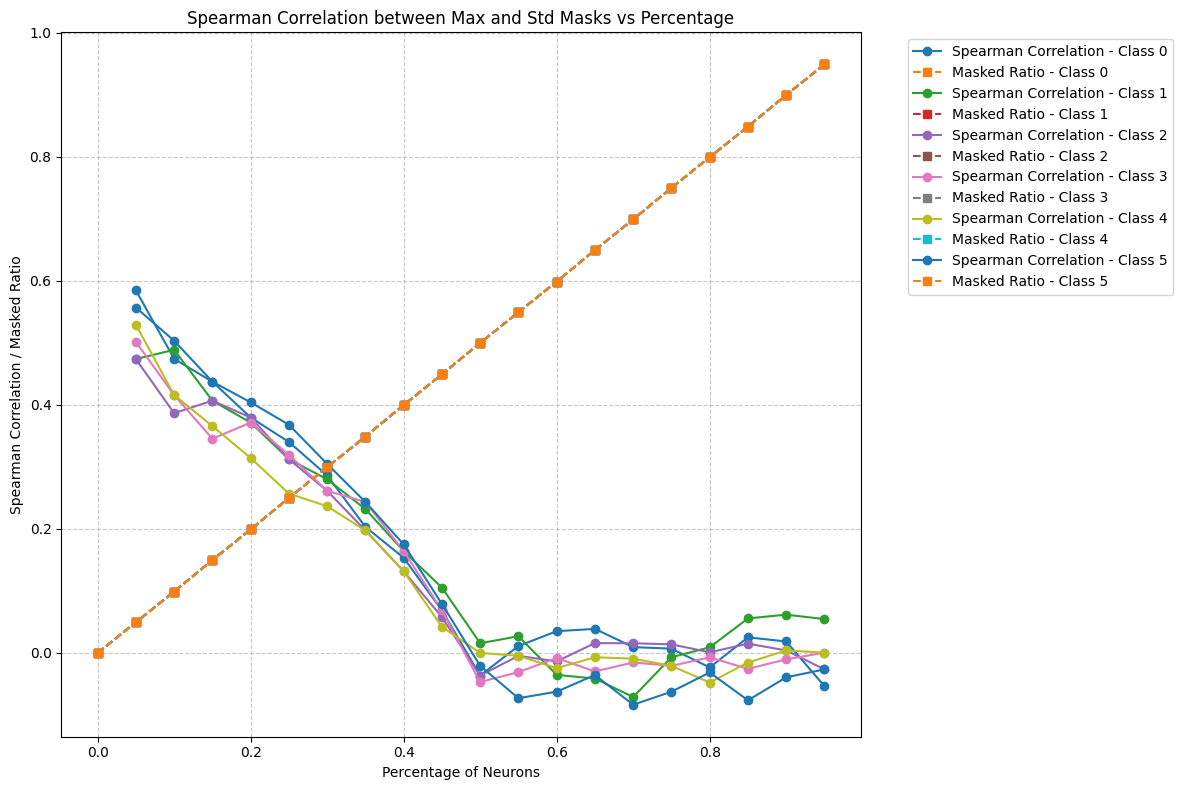


Creating individual class plots...


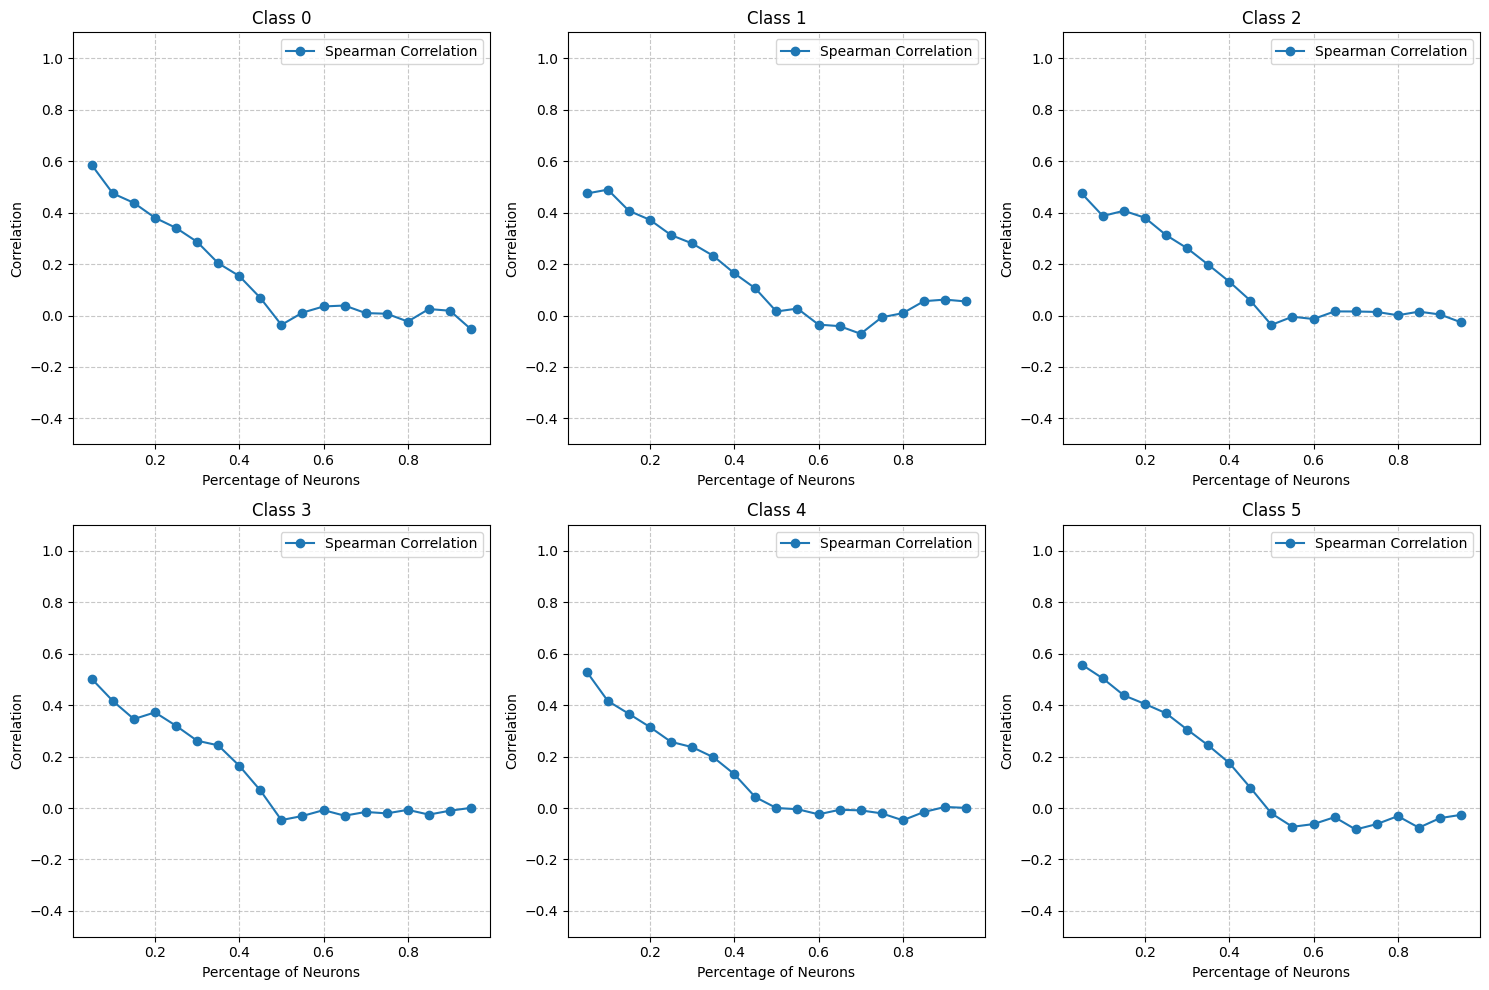


Detailed Statistics:

Class 0:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 1:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 2:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 3:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 4:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 5:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949


{0: {'spearman_correlation': [nan,
   0.5847152126892573,
   0.474292668086401,
   0.4375124841866968,
   0.37969073808385145,
   0.3402777777777777,
   0.2862453531598513,
   0.20334328358208956,
   0.15346188359818266,
   0.0685168054270737,
   -0.03645833333333334,
   0.011149768512177083,
   0.035121400338791645,
   0.03879133732148312,
   0.009407724491523373,
   0.006944444444444443,
   -0.023393544566183002,
   0.025174529299767292,
   0.01847501268630067,
   -0.05349794238683128],
  'total_masked': [0,
   38,
   76,
   115,
   153,
   192,
   230,
   268,
   307,
   345,
   384,
   422,
   460,
   499,
   537,
   576,
   614,
   652,
   691,
   729],
  'total_neurons': 768},
 1: {'spearman_correlation': [nan,
   0.473972602739726,
   0.48889564952844533,
   0.4068313469605166,
   0.3715287741112706,
   0.31249999999999994,
   0.28003879101341517,
   0.232,
   0.16431493637256492,
   0.10535512385651145,
   0.015625000000000003,
   0.02692929348272745,
   -0.03534726143421795,
 

In [17]:
import importlib 

import plot_correlation  # import the entire module
importlib.reload(plot_correlation)
from plot_correlation import create_correlation_plots
create_correlation_plots(all_fc_vals, num_classes)